# Signal vs. background classification in NEXT

In [1]:
# %matplotlib inline

import os
import h5py
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import tables            as tb
# import pandas            as pd

from glob                import glob
# from matplotlib.patches  import Ellipse

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

from torch.autograd   import Variable
from torch.autograd   import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

mpl.rcParams.update({'font.size': 14})

#### Enable/disable CUDA

In [2]:
CUDA_enabled = False
if(CUDA_enabled):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Definition of key variables
The directory structure followed is:

`$NEXTHOME/data`   -- contains datafiles `signal.h5` and `background.h5`<br>
`$NEXTHOME/models` -- contains saved models

In [3]:
# data dimensions
xdim = 20
ydim = 20
zdim = 60

# directory structure
basedir = os.environ['NEXTHOME']
datadir   = f"{basedir}/data"
modelsdir = f"{basedir}/models"

datafile_signal     = f"{datadir}/signal.h5"
datafile_background = f"{datadir}/background.h5"

## Preview events
The events are 20x20x60 maps of simulated voxelized tracks. One can get a good idea of what these tracks look like by summing over the z-dimension and plotting this projection in x-y.

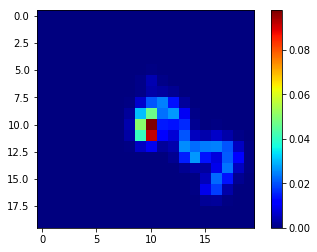

In [4]:
evtnum = 0

with tb.open_file(datafile_background, "r") as file:
    event = file.root.maps[evtnum]

plt.imshow(np.sum(event,axis=2),cmap='jet')
plt.imshow(np.sum(event,axis=2),cmap='jet')
plt.colorbar();

## Data preparation
Here a Pytorch `Dataset` is created for batching 3D maps of NEXT track topologies. The files containing signal and background events are provided, followed by a range of events. The idea is that the training, validation, and test sets can be created using events from the same files via differing ranges of events. The flag `load_to_memory`, when set to `True`, loads all events into memory at once for faster batching.

In [5]:
class NEXTDataset(Dataset):
    
    def __init__(self, datafile_signal, datafile_background, nstart=0, nend=0, load_to_memory=True):
        
        # Save inputs for later use.
        self.datafile_signal     = datafile_signal
        self.datafile_background = datafile_background
        self.load_to_memory      = load_to_memory
        
        # Read datafiles and get the tracks
        signal     = tb.open_file(datafile_signal    , "r").root.maps 
        background = tb.open_file(datafile_background, "r").root.maps
        
        # Get the number of signal and background events and ensure that we have the same.
        nsignal     = signal    .shape[0]
        nbackground = background.shape[0]
        nmin        = min(nsignal, nbackground)
        
        # Ensure nend > nstart.
        if (nend <= nstart):
            nend = nmin
            
        # Load everything at once.
        if (load_to_memory):
            self.data   = np.vstack((signal[nstart:nend]      , background[nstart:nend]))
            self.labels = np.vstack((np.ones((nend-nstart, 1)), np.zeros((nend-nstart, 1))))
                                    
        # Save the final values of nstart and nend.
        self.nstart = nstart
        self.nend   = nend
        
        print("Created dataset from events", nstart, "to", nend, "of", nmin, "available signal and background events")

    def __len__(self):
        return 2*(self.nend-self.nstart)

    def __getitem__(self, idx):
        # Choose the data, label pair at the specified index if everything is already loaded into memory.
        if (self.load_to_memory):
            event = torch.tensor(self.data  [idx]).float()
            label = torch.tensor(self.labels[idx]).float()
        
        # Otherwise find the event in the correct file.
        else:
            # Second half of indices correspond to background.
            nrange = (self.nend-self.nstart)
            if(idx >= nrange):
                datafile = self.datafile_background
                idx     -= nrange
                label    = torch.tensor([0]).float()
            else:
                datafile = self.datafile_signal
                label    = torch.tensor([1]).float()

            # Open the correct file and extract the element corresponding to this index.
            with tb.open_file(datafile, "r") as file:
                event = torch.tensor(file.root.maps[idx])
                                    
        if (CUDA_enabled):
            return event.cuda(), label.cuda()
        else:
            return event, label

In [6]:
Dataset = NEXTDataset(datafile_signal, datafile_background, nstart=0, nend=10)

Created dataset from events 0 to 10 of 89544 available signal and background events


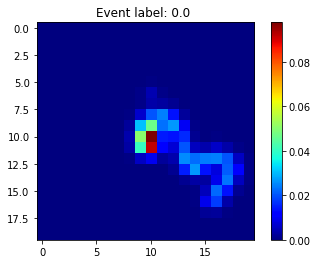

In [7]:
event, label = Dataset[10]

plt.title(f"Event label: {label.item()} ")
plt.imshow(event.sum(dim=2), cmap='jet')
plt.imshow(event.sum(dim=2), cmap='jet')
plt.colorbar();

## Create a neural network
Here the neural network architecture is defined.

In [8]:
class FCNet(nn.Module):

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(xdim*ydim*zdim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(-1, xdim*ydim*zdim)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return x

In [9]:
net = FCNet()
summary(net, (xdim, ydim, zdim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]         768,032
            Linear-2                    [-1, 1]              33
Total params: 768,065
Trainable params: 768,065
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.00
Params size (MB): 2.93
Estimated Total Size (MB): 3.02
----------------------------------------------------------------


In [12]:
print("Process an event:   ", net(event))

Process an event:    tensor([[0.1143]], grad_fn=<AddmmBackward>)


In [11]:
# parameters = list(net.parameters())
# print("Number of set of parameters:", len(parameters))

# for i, params in enumerate(parameters):
#     print(f"Number of parameters in set {i}:", list(params.shape))

## Train the network
Here functions for network training and validation are defined.

In [9]:
verbose = False

def train(model,epoch):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        # Compute the model result.
        output_score = model(data)
        
        # Compute the loss: note BCEWithLogitsLoss performs a sigmoid followed by binary cross entropy.
        m = torch.nn.BCEWithLogitsLoss()
        loss = m(output_score,target)
        
        loss.backward()
        optimizer.step()

        if verbose and (batch_idx % 10 == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t logits_max: {:.6f}\t logits_min: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item(), 
                output_score[:,0].data.max(), output_score[:,0].data.min()))
            
        losses_epoch.append(loss.data.item())
        
    print("---EPOCH",epoch,"AVG TRAIN LOSS:",np.mean(losses_epoch))


def val(model,epoch):
    losses_epoch = []
    for batch_idx, (data, target) in enumerate(val_loader):
        
        if(CUDA_enabled):
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # Compute the model result.
        output_score = model(data)
        
        # Compute the loss.
        m = torch.nn.BCEWithLogitsLoss()
        loss = m(output_score,target)
        
        if verbose and (batch_idx % 10 == 0):
            print('--Val Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t logits_max: {:.6f}\t logits_min: {:.6f}'.format(
                epoch, batch_idx * len(data), len(val_loader.dataset),
                100. * batch_idx / len(val_loader), loss.data.item(), 
                output_score[:,0].data.max(), output_score[:,0].data.min()))
        losses_epoch.append(loss.data.item())
        
    print("---EPOCH",epoch,"AVG VAL LOSS:",np.mean(losses_epoch))

Create datasets and data loaders for training and validation.

In [10]:
dataset_train = NEXTDataset(datafile_signal, datafile_background, 0, 5000)
train_loader  = DataLoader(dataset_train, batch_size=200, shuffle=True)

dataset_val   = NEXTDataset(datafile_signal, datafile_background, 5000, 6000)
val_loader    = DataLoader(dataset_val, batch_size=200, shuffle=True)

Created dataset from events 0 to 5000 of 89544 available signal and background events
Created dataset from events 5000 to 6000 of 89544 available signal and background events


Set some key flags for training:
- **load_model**: set to True to load the specified model. If training is True, the model will be loaded before any training begins.
- **modelfile**: the model to be loaded
- **training**: set to True to perform training
- **lrate**: the learning rate to use for training

Note: to perform testing with an already trained model, set `load_model` to `True` and `training` to `False`.

In [12]:
lrate = 1e-2
load_model = False
training  = True
modelfile = f"{modelsdir}/model_NEXT_0.pt"

In [13]:
# Define the model.
model = FCNet()
if(CUDA_enabled):
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(modelfile))
    model.eval()

# Train the model.
if(training):
    for epoch in range(0, 3):
        print("\nEpoch: ",epoch)
        model.train()
        train(model,epoch)
        with torch.no_grad():
            model.eval()
            val(model,epoch)
        torch.save(model.state_dict(), f"{modelsdir}/model_NEXT_{epoch}.pt")


Epoch:  0


/Users/gonzalo/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


---EPOCH 0 AVG TRAIN LOSS: 0.6940331864356994
---EPOCH 0 AVG VAL LOSS: 0.6903018355369568

Epoch:  1
---EPOCH 1 AVG TRAIN LOSS: 0.6858988463878631
---EPOCH 1 AVG VAL LOSS: 0.6837212860584259

Epoch:  2
---EPOCH 2 AVG TRAIN LOSS: 0.6774522423744201
---EPOCH 2 AVG VAL LOSS: 0.6794553518295288


## Test the model
Create a test dataset and loader

In [13]:
dataset_test  = NEXTDataset(datafile_signal, datafile_background, 8000, 10000)
test_loader   = DataLoader(dataset_test, batch_size=200, shuffle=True)

Created dataset from events 8000 to 10000 of 89544 available signal and background events


Run the model (in batches) on each data sample.

In [14]:
sig = nn.Sigmoid()
model.eval()

all_cls, all_tgt = np.array([]), np.array([])
test_iter = iter(test_loader)
for (data,tgt) in test_iter:
    
    # Get the classification for this batch.
    if(CUDA_enabled):
        data_cuda = data.cuda()
        cls_gpu = sig(model(data_cuda))
        cls = np.array(cls_gpu.cpu().detach().squeeze())
    else:
        cls = np.array(sig(model(data)).detach().squeeze())
 
    # Convert the target to numpy format.
    tgt = np.array(tgt.cpu().squeeze())
    
    all_cls = np.concatenate([all_cls,cls],axis=0)
    all_tgt = np.concatenate([all_tgt,tgt],axis=0)

Compute the signal efficiency vs. background rejection for several thresholds.
- the **signal efficiency** is the number of correctly predicted (prediction >= threshold) signal events divided by the total number of signal events
- the **background rejection** is the number of correctly predicted (prediction < threshold) background events divided by the total number of background events

In [15]:
npoints = 100
signal_eff, background_rej = [],[]
for th in np.arange(0,1,1./npoints):
    
    # Get the total number of each class.
    total_signal     = np.sum(all_tgt)
    total_background = len(all_tgt) - total_signal
    
    # Get the number of correctly classified for each class.
    correct_signal     = np.sum(all_cls[all_tgt == 1] >= th)
    correct_background = np.sum(all_cls[all_tgt == 0] < th)
    
    signal_eff.append(1.0*correct_signal/total_signal)
    background_rej.append(1.0*correct_background/total_background)

Plot the results.

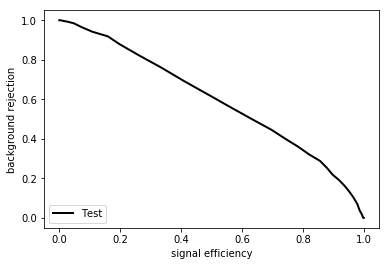

In [16]:
plt.plot(signal_eff,background_rej,color='black',label='Test',lw=2)
plt.xlabel("signal efficiency")
plt.ylabel("background rejection")
plt.legend(loc=3)

## Things to try:
1. Design an improved network.
2. Evaluate individual events: plot the event along with its classification probability. Is this how you would have classified the event? 